# Figure 3

In [1]:
import pickle

import pyleoclim as pyleo
import numpy as np
import ammonyte as amt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches

In [2]:
#Defining group lists for easy loading
group_names = ['ODP 925','ODP 927','ODP 929','ODP 846','ODP 849']

Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order
Time axis values sorted in ascending order


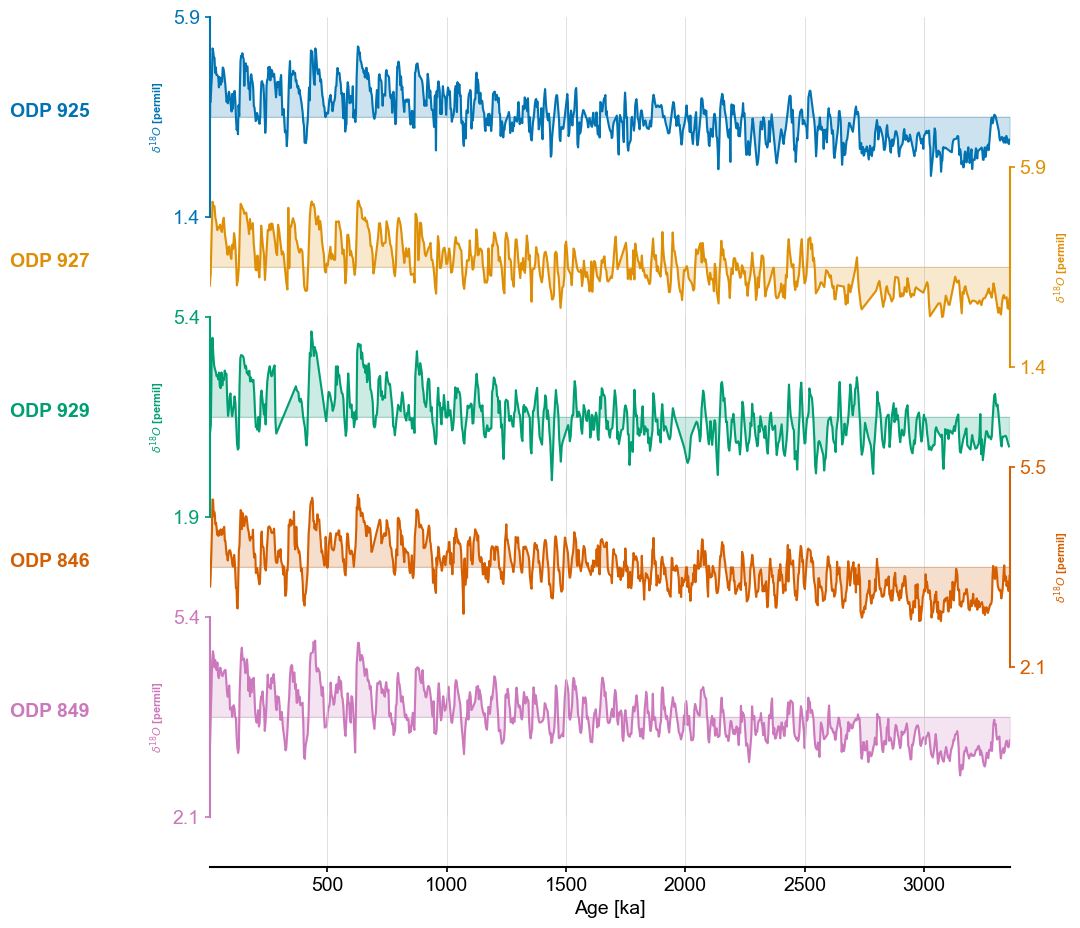

In [3]:
series_list = []
color_list = sns.color_palette('colorblind')

for name in group_names:
    with open('./data/LR04cores_spec_corr/'+name[-3:]+'_LR04age.txt','rb') as handle:
        lines = handle.readlines()
        time = []
        d18O = []
        for x in lines:
            line_time = float(format(float(x.decode().split()[1]),'10f'))
            line_d18O = float(format(float(x.decode().split()[2]),'10f'))
            #There is a discontinuity in 927 around 4000 ka, we'll just exclude it
            if line_time <= 4000:
                time.append(line_time)
                d18O.append(line_d18O)
        series = pyleo.Series(value=d18O,
                              time=time,
                              label=name,
                              time_name='Yr',
                              time_unit='ka',
                              value_name=r'$\delta^{18}O$',
                              value_unit='permil')
    series_list.append(series)
    
max_time = min([max(series.time) for series in series_list])
min_time = max([min(series.time) for series in series_list])

ms = pyleo.MultipleSeries([series.slice((min_time,max_time)).interp() for series in series_list])
fig,ax = ms.stackplot(colors=color_list[:len(ms.series_list)],figsize=(8,10))

In [4]:
#Initialize line colors
line_colors = []
fill_colors = []

for i in range(10):
    line_colors.append(sns.color_palette('colorblind')[i])
    fill_colors.append(sns.color_palette('colorblind')[i])

In [5]:
def detect_transitions(series,transition_interval=None):
    '''Function to detect transitions across a confidence interval
    
    Parameters
    ----------
    
    series : pyleo.Series, amt.Series
        Series to detect transitions upon
        
    transition_interval : list,tuple
        Upper and lower bound for the transition interval
    
    Returns
    -------
    
    transitions : list
        Timing of the transitions of the series across its confidence interval
    '''
    series_fine = series.interp(step=1)
    
    if transition_interval is None:
        upper, lower = amt.utils.sampling.confidence_interval(series)
    else:
        upper, lower = transition_interval

    above_thresh = np.where(series_fine.value > upper,1,0)
    below_thresh = np.where(series_fine.value < lower,1,0)

    transition_above = np.diff(above_thresh)
    transition_below = np.diff(below_thresh)

    upper_trans = series_fine.time[1:][np.diff(above_thresh) != 0]
    lower_trans = series_fine.time[1:][np.diff(below_thresh) != 0]

    full_trans = np.zeros(len(transition_above))

    last_above = 0
    last_below = 0
    for i in range(len(transition_above)):
        above = transition_above[i]
        below = transition_below[i]
        if above != 0:
            if last_below+above == 0:
                loc = int((i+below_pointer)/2)
                full_trans[loc] = 1
                last_below=0
            last_above = above
            above_pointer = i
        if below != 0:
            if last_above + below == 0:
                loc = int((i+above_pointer)/2)
                full_trans[loc] = 1
                last_above=0
            last_below = below
            below_pointer = i

    transitions = series_fine.time[1:][full_trans != 0]
    
    return transitions

In [6]:
with open('./data/0_2500_I65_staged.pkl','rb') as handle:
    initial_series = pickle.load(handle)

In [7]:
lp_series_list = []
syn_series_list = []
m = 13
tau=5

for idx,series in enumerate(ms.series_list):
    core_series = series.slice((min(initial_series.time),max(initial_series.time)))
    binned_series = initial_series.bin(time_axis=core_series.time).convert_time_unit('Years').interp().detrend(method='savitzky-golay')
    syn_series_list.append(binned_series)
    td = amt.TimeEmbeddedSeries(binned_series.interp(),m,tau)
    eps = td.find_epsilon(1,.05,.01)
    rm = eps['Output']
    lp_series = rm.laplacian_eigenmaps(50,5).convert_time_unit('ka')
    lp_series.label = series.label
    lp_series.value_name='FI'
    lp_series.value_unit='NA'
    lp_series_list.append(lp_series)

syn_ms = pyleo.MultipleSeries(syn_series_list)

Initial density is 0.0013
Initial density is not within the tolerance window, searching...
Epsilon: 1.4870, Density: 0.0025
Epsilon: 1.9622, Density: 0.0047
Epsilon: 2.4149, Density: 0.0097
Epsilon: 2.8177, Density: 0.0236
Epsilon: 3.0822, Density: 0.0423
Epsilon: 3.0822, Density: 0.0423.


/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:163: UserWarning: No time_name parameter provided. Assuming "Time".
  warnings.warn('No time_name parameter provided. Assuming "Time".', UserWarning)


Initial density is 0.0018
Initial density is not within the tolerance window, searching...
Epsilon: 1.4825, Density: 0.0018
Epsilon: 1.9641, Density: 0.0046
Epsilon: 2.4183, Density: 0.0129
Epsilon: 2.7897, Density: 0.0298
Epsilon: 2.9915, Density: 0.0467
Epsilon: 2.9915, Density: 0.0467.


/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:163: UserWarning: No time_name parameter provided. Assuming "Time".
  warnings.warn('No time_name parameter provided. Assuming "Time".', UserWarning)


Initial density is 0.0015
Initial density is not within the tolerance window, searching...
Epsilon: 1.4849, Density: 0.0018
Epsilon: 1.9672, Density: 0.0045
Epsilon: 2.4226, Density: 0.0090
Epsilon: 2.8327, Density: 0.0201
Epsilon: 3.1320, Density: 0.0386
Epsilon: 3.2459, Density: 0.0500
Epsilon: 3.2459, Density: 0.0500.


/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:163: UserWarning: No time_name parameter provided. Assuming "Time".
  warnings.warn('No time_name parameter provided. Assuming "Time".', UserWarning)


Initial density is 0.0013
Initial density is not within the tolerance window, searching...
Epsilon: 1.4873, Density: 0.0026
Epsilon: 1.9614, Density: 0.0047
Epsilon: 2.4146, Density: 0.0094
Epsilon: 2.8210, Density: 0.0231
Epsilon: 3.0904, Density: 0.0415
Epsilon: 3.0904, Density: 0.0415.


/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:163: UserWarning: No time_name parameter provided. Assuming "Time".
  warnings.warn('No time_name parameter provided. Assuming "Time".', UserWarning)


Initial density is 0.0015
Initial density is not within the tolerance window, searching...
Epsilon: 1.4854, Density: 0.0023
Epsilon: 1.9628, Density: 0.0049
Epsilon: 2.4137, Density: 0.0114
Epsilon: 2.7998, Density: 0.0262
Epsilon: 3.0380, Density: 0.0431
Epsilon: 3.0380, Density: 0.0431.


/Users/alexjames/Documents/GitHub/Pyleoclim_util/pyleoclim/core/series.py:163: UserWarning: No time_name parameter provided. Assuming "Time".
  warnings.warn('No time_name parameter provided. Assuming "Time".', UserWarning)


(<Figure size 1000x400 with 1 Axes>,
 <Axes: xlabel='Age [ka]', ylabel='Ice Volume'>)

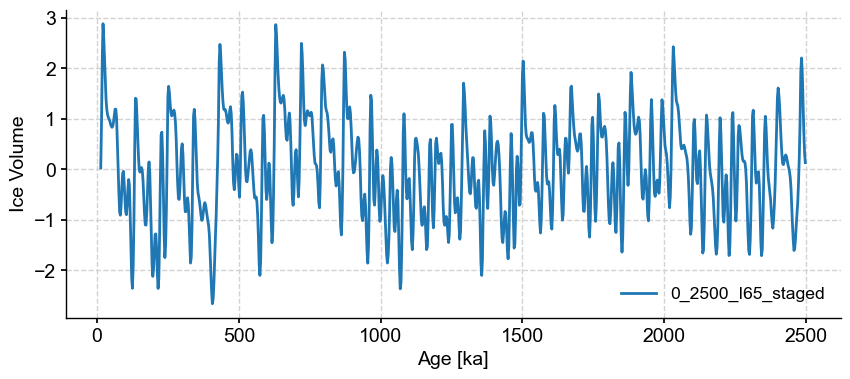

In [8]:
syn_ms.series_list[0].convert_time_unit('ka').plot()

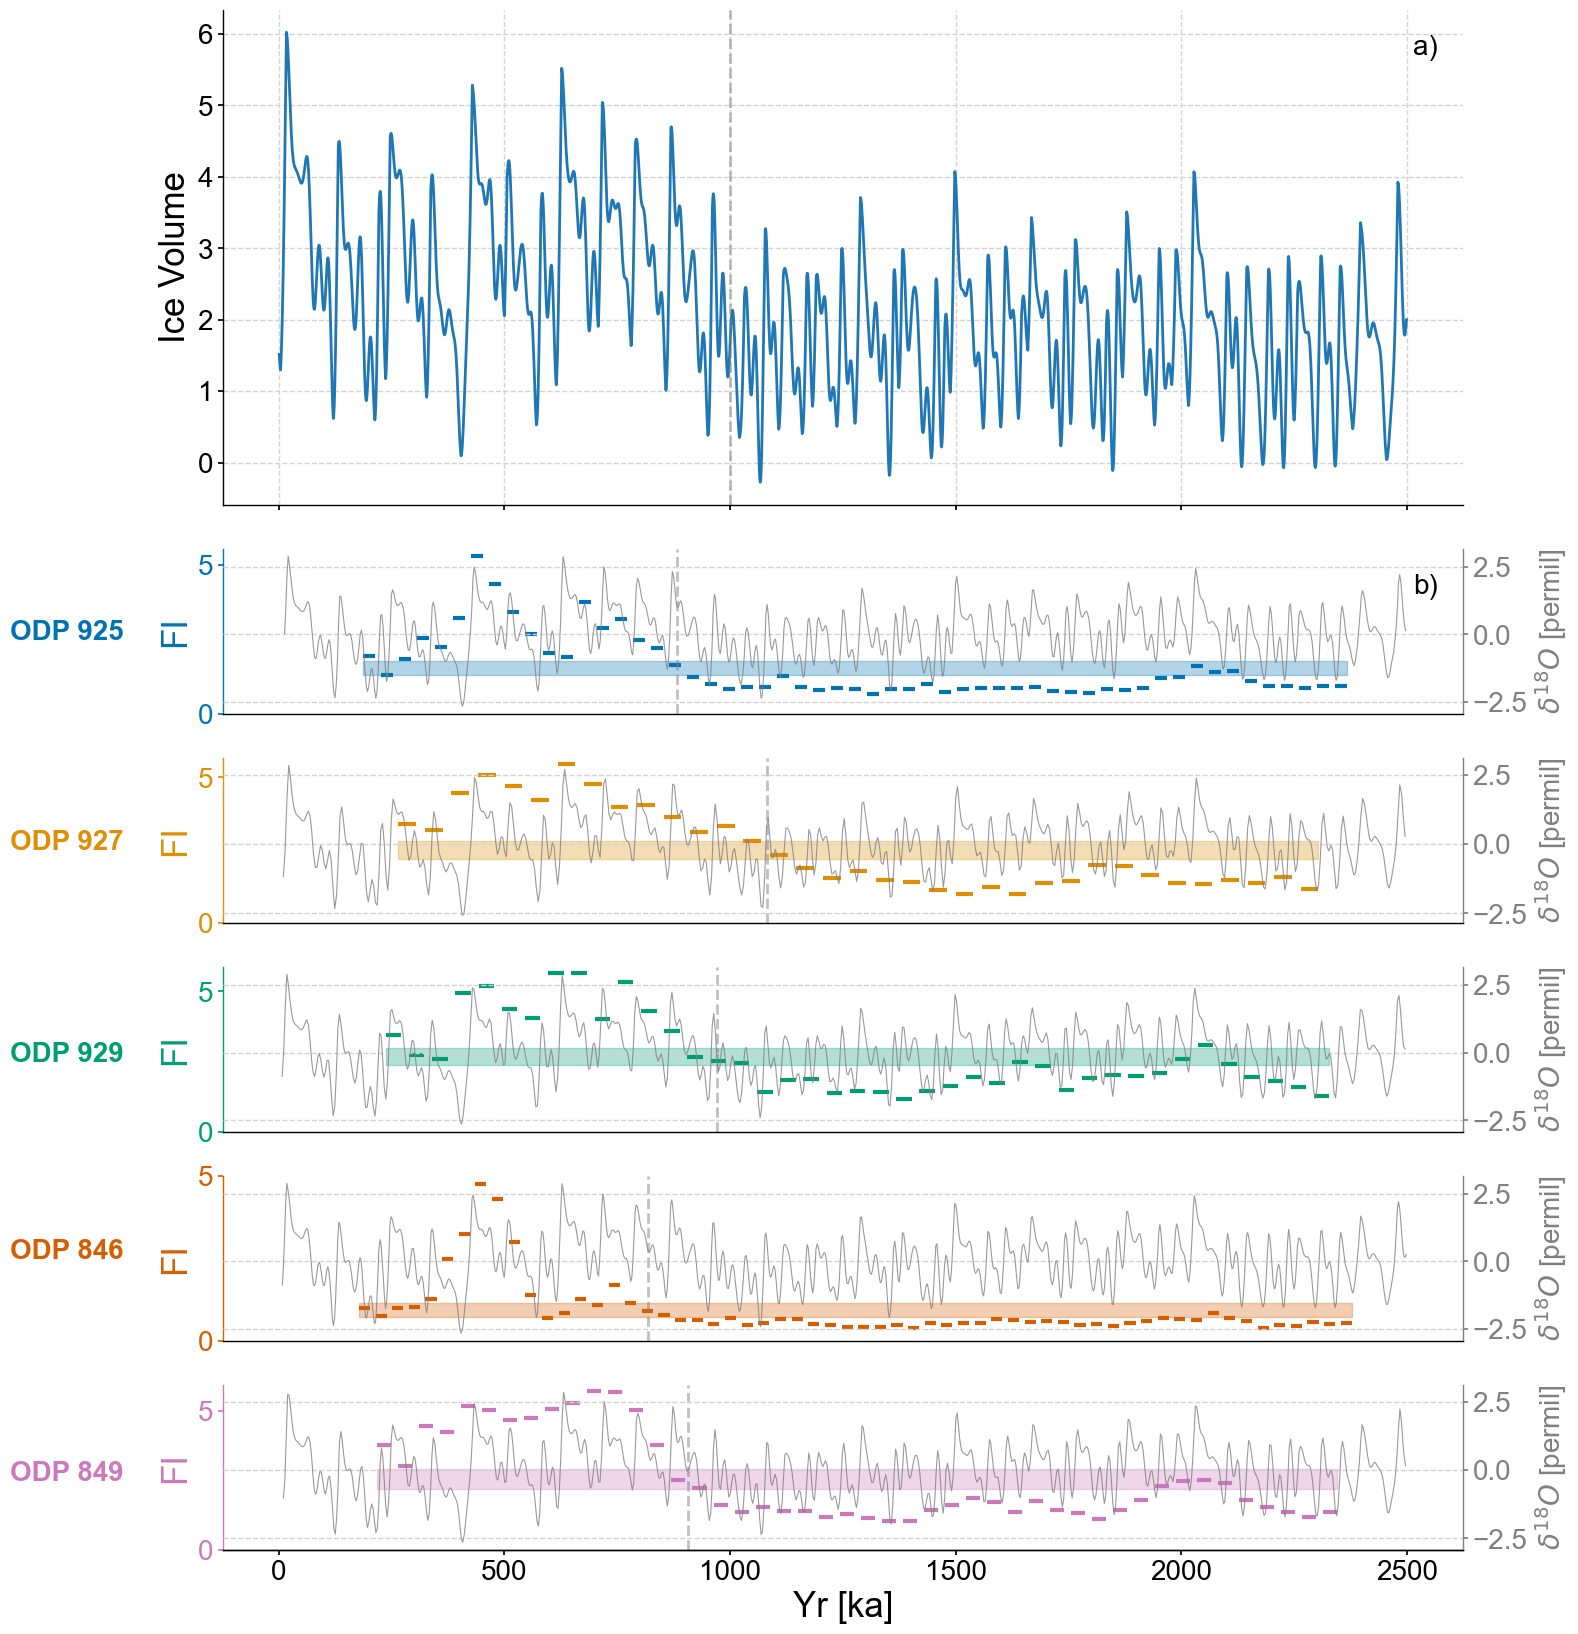

In [9]:
#Production figure

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig,axes = plt.subplots(nrows=len(group_names)+1,ncols=1,sharex=True,figsize=(16,20),gridspec_kw={'height_ratios':[3,1,1,1,1,1]})
transition_timing = []

initial_series.plot(xlabel='',legend=False,ax=axes[0])
axes[0].yaxis.label.set_fontsize(25)
axes[0].axvline(1000,color='grey',linestyle='dashed',alpha=.5)

for idx,lp_series in enumerate(lp_series_list):
    ts = lp_series
    ts.label = lp_series.label
    ts.value_name = 'FI'
    ts.value_unit = None
    ts.time_name = 'Yr'
    ts.time_unit = 'ka'

    ax = axes[idx+1]
    ts_smooth = amt.utils.fisher.smooth_series(ts,3)
    upper, lower = amt.utils.sampling.confidence_interval(ts)
    transitions=detect_transitions(ts_smooth,transition_interval=(upper,lower))

    transition_timing.append(transitions[np.abs(transitions-1000)==np.min(np.abs(transitions-1000))])

    ts.confidence_smooth_plot(
        ax=ax,
        background_series = syn_ms.series_list[idx].convert_time_unit('ka'),
        transition_interval=(upper,lower),
        block_size=3,
        color=color_list[idx],
        figsize=(12,6),
        legend=True,
        lgd_kwargs={'loc':'upper left'},
        hline_kwargs={'label':None},
        background_kwargs={'ylabel':'$\delta^{18}O$ [permil]','legend':False,'linewidth':.8,'color':'grey','alpha':.8})

    ax.axvline(transition_timing[idx],color='grey',linestyle='dashed',alpha=.5)
    
    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    ax.text(x=-.08, y = 2.5, s = ts.label, horizontalalignment='right', transform=trans, color=color_list[idx], weight='bold',fontsize=20)
        
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_label_position('left')
    ax.yaxis.tick_left()
    ax.get_legend().remove()
    ax.set_title(None)
    ax.grid(visible=False,axis='y')
    if idx != len(group_names)-1:
        ax.set_xlabel(None)
        ax.spines[['bottom']].set_visible(False)
        ax.tick_params(bottom=False)
    ax.xaxis.label.set_fontsize(25)
    ax.yaxis.label.set_fontsize(25)
    ax.set_yticks(ticks=np.array([0,5]))

patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='a)')
axes[0].legend(handles=[patch],loc='upper right')

patch = mpatches.Patch(fc="w", fill=False, edgecolor='none', linewidth=0,label='b)')
axes[1].legend(handles=[patch],loc='upper right')